# Imports

In [1]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
from tqdm.notebook import tqdm
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
import timm
from sklearn.model_selection import KFold

# Config

In [2]:
class CFG:
    seed = 888
    debug = False
    one_fold = False
    base_dir = pathlib.Path(".")
    path_train = base_dir / "train.csv"
    spec_dir =  "EEG_Spectrograms"
    transform = transforms.Resize((768, 768), antialias=False)
    model_name = "tf_efficientnet_b0.ns_jft_in1k"
    n_fold = 5
    epochs = 5
    batch_size = 8
    lr = 0.001

def picklesave(obj,file):
    ff = open(file,'wb')
    pickle.dump(obj,ff)
    ff.close()

def pickleload(file):
    ff = open(file,'rb')
    obj = pickle.load(ff)
    ff.close()
    return obj# Config

# Load data
- We classify the spectrogram directly.
- As a label we use the aggregated the votes per spectrogram slice

In [3]:
train_df = pd.read_csv("updated_train.csv")
spectrograms = pickleload('specs.pkl')

In [4]:
label_columns = train_df.filter(like="_vote").columns.to_list()
TARGETS = train_df.columns[-6:]
TARGETS

Index(['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote',
       'other_vote'],
      dtype='object')

In [5]:
data = train_df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
data.columns = ['spec_id','min']

tmp = train_df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
data['max'] = tmp

tmp = train_df.groupby('eeg_id')[['patient_id']].agg('first')
data['patient_id'] = tmp

tmp = train_df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    data[t] = tmp[t].values
    
y_data = data[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
data[TARGETS] = y_data

tmp = train_df.groupby('eeg_id')[['expert_consensus']].agg('first')
data['target'] = tmp

data = data.reset_index()
print('Train non-overlapp eeg_id shape:', data.shape )
data["path"] = data.eeg_id.map(lambda x: f"EEG_Spectrograms/{x}.npy")

data.head()

Train non-overlapp eeg_id shape: (16064, 12)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target,path
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other,EEG_Spectrograms/568657.npy
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD,EEG_Spectrograms/582999.npy
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other,EEG_Spectrograms/642382.npy
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD,EEG_Spectrograms/751790.npy
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other,EEG_Spectrograms/778705.npy


# Data Handling
- Spectrogram is loaded, which contains spectrograms in 4 different regions.
- All together they are clipped, log-transformed and the standardized.
- Finally it is resized as an image.
- Note, since the spectrograms have sometimes very different lenghts this creates a certain distortion.

In [6]:
def preprocess(x):
    m, s = x.mean(), x.std()
    x = (x - m) / (s + 1e-6)
    return x

def preprocess2(x):
    x = np.clip(x, np.exp(-6), np.exp(10))
    x = np.log(x)
    m, s = x.mean(), x.std()
    x = (x - m) / (s + 1e-6)
    return x

In [7]:
class SpecDataset(Dataset):
    
    def __init__(self, df, transform=CFG.transform):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        x = np.load(row.path)
#         print(x.shape)
        x = [x[:,:,i+0:i+1] for i in range(6)]
        x1 = np.concatenate(x,axis=0)[:,:,0]

        x1 = preprocess(x1)
#         print(x1.shape)

        # input
        x = spectrograms[row.spec_id]
        r = int( (row['min'] + row['max'])//4 )
        x = x[:,r:r+300]

        x2 = preprocess2(x)
        x2 = torch.Tensor(x2[None, :])
        x2 = np.array(CFG.transform(x2))[0]
#         print(x2.shape)

        x = np.concatenate([x1,x2])
#         print(x.shape)

        
        x = torch.Tensor(x[None, :])
        if self.transform:
            x = self.transform(x)
        y = np.array(row.loc[label_columns].values, 'float32')
        y = torch.Tensor(y)
        return x, y

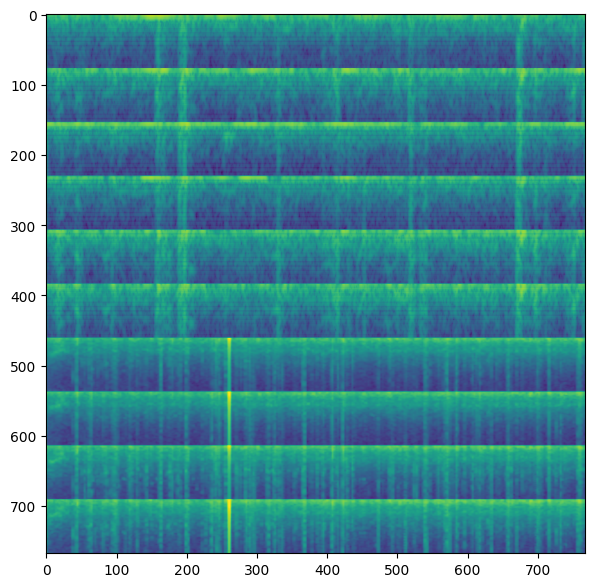

In [8]:
ds = SpecDataset(df=data.iloc[:50])
ld = DataLoader(dataset=ds, batch_size=CFG.batch_size, drop_last=True, num_workers=0)
x, y = next(iter(ld))

plt.figure(figsize=(10,7))
plt.imshow(np.array(x[0, 0].cpu()))
plt.show()

# Model

In [9]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"DEVICE: {DEVICE}")

DEVICE: cuda


# Training Utils
- Create Kullback-Leibler Divergence loss from logits.
- Compute loss utility.

In [12]:
def KLDivLoss(logit, target):
    log_prob = F.log_softmax(logit, dim=1)
    return F.kl_div(log_prob, target, reduction="batchmean")

def KL_loss(p,q):
    epsilon=10**(-15)
    p=torch.clip(p,epsilon,1-epsilon)
    q = nn.functional.log_softmax(q,dim=1)
    return torch.mean(torch.sum(p*(torch.log(p)-q),dim=1))

def compute_loss(model, data_loader):
    model.eval()
    l_loss = []
    with torch.no_grad():
        for x, y in data_loader:
            y_pred = model(x.to(DEVICE))
            loss = KLDivLoss(y_pred, y.to(DEVICE))
            l_loss.append(loss.item())
    return np.mean(l_loss) 

In [13]:
KLDivLoss(y_out, y.to(DEVICE)), KL_loss(p=y.to(DEVICE), q=y_out)

(tensor(1.9305, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1.9305, device='cuda:0', grad_fn=<MeanBackward0>))

# Training
- Uses plain 5 fold training strategy.
- Runs for all epochs and checkpoints model weights if the validation loss improves.

In [14]:
if CFG.debug:
    data = data.iloc[:400]
gc.collect()

0

Fold 0:


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1606 [00:00<?, ?it/s]

Epoch 0
Train Loss:   0.799216, Valid Loss:   0.660835
Loss improves from        inf to   0.660835


  0%|          | 0/1606 [00:00<?, ?it/s]

Epoch 1
Train Loss:   0.594689, Valid Loss:    0.56182
Loss improves from   0.660835 to    0.56182


  0%|          | 0/1606 [00:00<?, ?it/s]

Epoch 2
Train Loss:   0.539151, Valid Loss:   0.535741
Loss improves from   0.561820 to   0.535741


  0%|          | 0/1606 [00:00<?, ?it/s]

Epoch 3
Train Loss:   0.489672, Valid Loss:     0.5457


  0%|          | 0/1606 [00:00<?, ?it/s]

Epoch 4
Train Loss:   0.450323, Valid Loss:   0.586097

Best loss Model training with 0.535740992582556



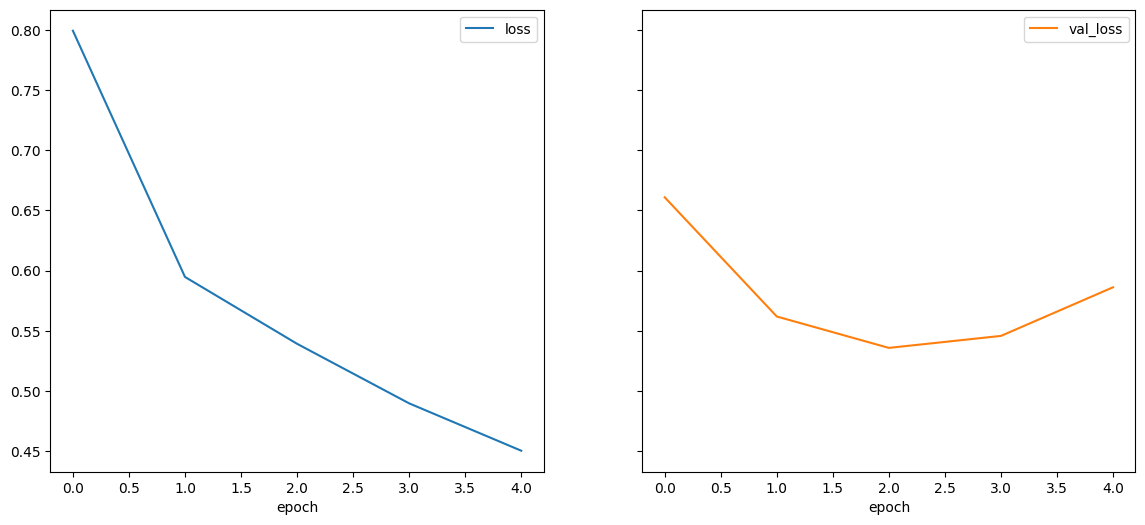

Fold 1:


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1606 [00:00<?, ?it/s]

Epoch 0
Train Loss:   0.800787, Valid Loss:   0.618316
Loss improves from        inf to   0.618316


  0%|          | 0/1606 [00:00<?, ?it/s]

Epoch 1
Train Loss:   0.583856, Valid Loss:   0.533309
Loss improves from   0.618316 to   0.533309


  0%|          | 0/1606 [00:00<?, ?it/s]

Epoch 2
Train Loss:   0.529858, Valid Loss:   0.511038
Loss improves from   0.533309 to   0.511038


  0%|          | 0/1606 [00:00<?, ?it/s]

Epoch 3
Train Loss:   0.487987, Valid Loss:   0.537768


  0%|          | 0/1606 [00:00<?, ?it/s]

Epoch 4
Train Loss:   0.448152, Valid Loss:   0.533278

Best loss Model training with 0.5110376890544868



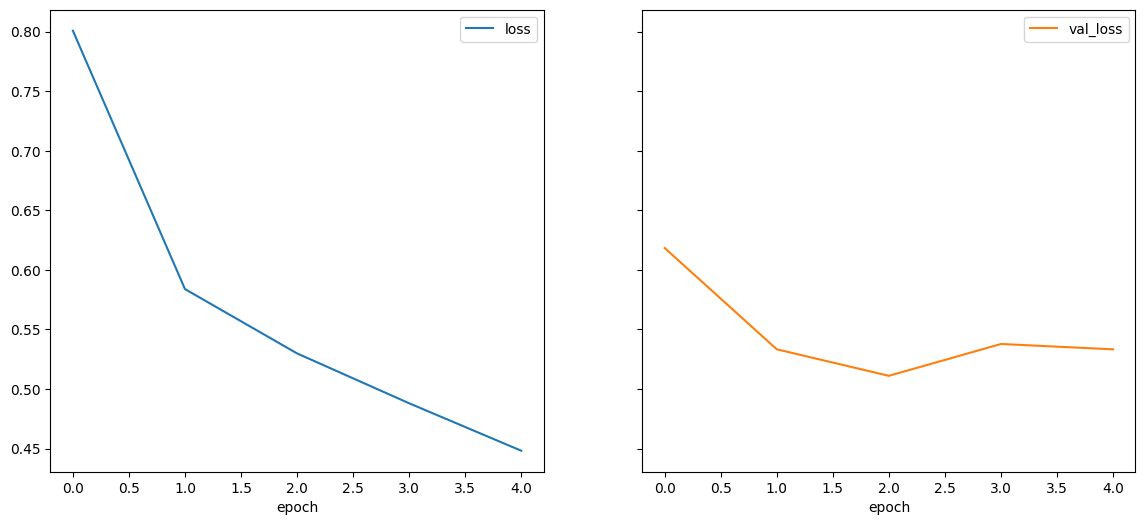

Fold 2:


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1606 [00:00<?, ?it/s]

Epoch 0
Train Loss:   0.785157, Valid Loss:    0.59729
Loss improves from        inf to    0.59729


  0%|          | 0/1606 [00:00<?, ?it/s]

Epoch 1
Train Loss:   0.589565, Valid Loss:   0.656627


  0%|          | 0/1606 [00:00<?, ?it/s]

Epoch 2
Train Loss:   0.529820, Valid Loss:   0.598989


  0%|          | 0/1606 [00:00<?, ?it/s]

Epoch 3
Train Loss:   0.490416, Valid Loss:   0.539856
Loss improves from   0.597290 to   0.539856


  0%|          | 0/1606 [00:00<?, ?it/s]

Epoch 4
Train Loss:   0.444843, Valid Loss:   0.542758

Best loss Model training with 0.539855796936436



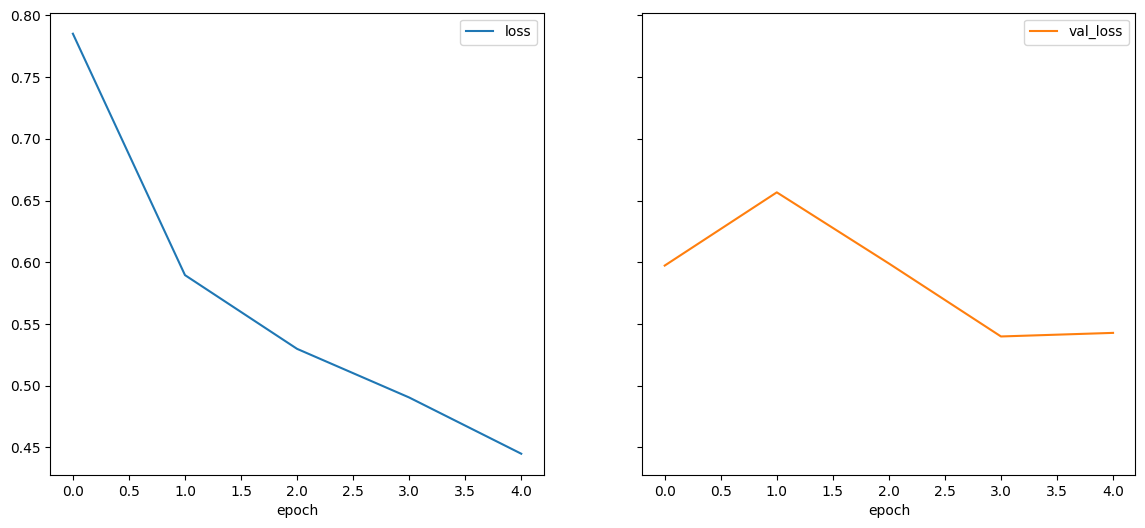

Fold 3:


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1606 [00:00<?, ?it/s]

Epoch 0
Train Loss:   0.798435, Valid Loss:   0.679667
Loss improves from        inf to   0.679667


  0%|          | 0/1606 [00:00<?, ?it/s]

Epoch 1
Train Loss:   0.596335, Valid Loss:   0.602378
Loss improves from   0.679667 to   0.602378


  0%|          | 0/1606 [00:00<?, ?it/s]

Epoch 2
Train Loss:   0.534204, Valid Loss:   0.611123


  0%|          | 0/1606 [00:00<?, ?it/s]

Epoch 3
Train Loss:   0.490290, Valid Loss:   0.518675
Loss improves from   0.602378 to   0.518675


  0%|          | 0/1606 [00:00<?, ?it/s]

Epoch 4
Train Loss:   0.448156, Valid Loss:   0.531192

Best loss Model training with 0.5186746299118545



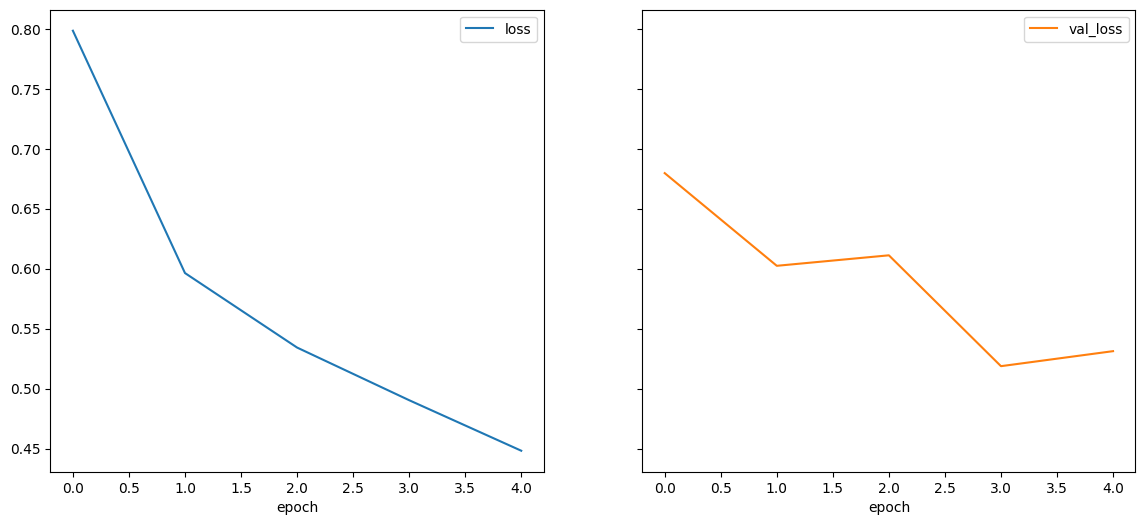

Fold 4:


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1606 [00:00<?, ?it/s]

Epoch 0
Train Loss:   0.798212, Valid Loss:   0.715048
Loss improves from        inf to   0.715048


  0%|          | 0/1606 [00:00<?, ?it/s]

Epoch 1
Train Loss:   0.608555, Valid Loss:   0.533254
Loss improves from   0.715048 to   0.533254


  0%|          | 0/1606 [00:00<?, ?it/s]

Epoch 2
Train Loss:   0.543574, Valid Loss:   0.521023
Loss improves from   0.533254 to   0.521023


  0%|          | 0/1606 [00:00<?, ?it/s]

Epoch 3
Train Loss:   0.505039, Valid Loss:   0.496595
Loss improves from   0.521023 to   0.496595


  0%|          | 0/1606 [00:00<?, ?it/s]

Epoch 4
Train Loss:   0.463494, Valid Loss:   0.471996
Loss improves from   0.496595 to   0.471996

Best loss Model training with 0.47199587790823694



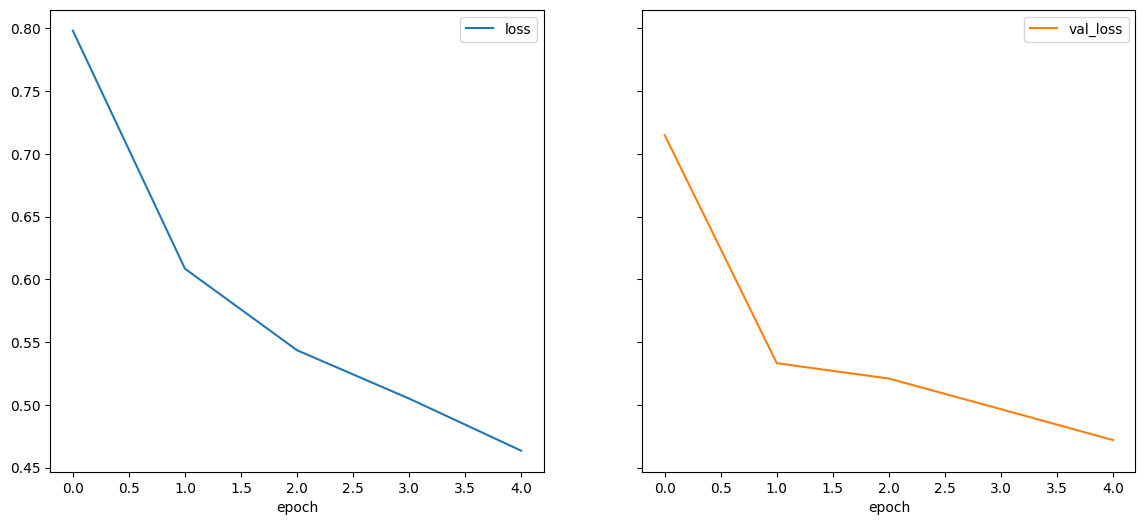

CPU times: total: 1d 2h 56min 34s
Wall time: 7h 11min 46s


0

In [15]:
%%time

kf = KFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)

l_best_loss = []
for fold, (iloc_train, iloc_valid) in enumerate(kf.split(data)):
    print(f"Fold {fold}:")

    train_ds = SpecDataset(df=data.iloc[iloc_train])
    valid_ds = SpecDataset(df=data.iloc[iloc_valid])
    train_loader = DataLoader(dataset=train_ds, shuffle=True, batch_size=CFG.batch_size, num_workers=0, drop_last=True)
    valid_loader = DataLoader(dataset=valid_ds, batch_size=CFG.batch_size, num_workers=0)
    
    model = timm.create_model(model_name=CFG.model_name, pretrained=True, num_classes=6, in_chans=1)
    model.to(DEVICE)
        
    optimizer = optim.AdamW(model.parameters(), lr=CFG.lr)
    scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=CFG.epochs)
    optimizer, scheduler
    best_loss = float("inf")
    history = []
    
    for epoch in tqdm(range(CFG.epochs)):
        model.train()
        l_loss = []
        for x, y in tqdm(train_loader):
            x, y = x.to(DEVICE), y.to(DEVICE)
            y_pred = model(x)
            loss = KLDivLoss(y_pred, y)
            l_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        train_loss = np.mean(l_loss)
        valid_loss = compute_loss(model, valid_loader)
        history.append((epoch, train_loss, valid_loss))
        print(f"Epoch {epoch}")
        print(f"Train Loss: {train_loss:>10.6f}, Valid Loss: {valid_loss:>10.6}")
        if valid_loss < best_loss:
            print(f"Loss improves from {best_loss:>10.6f} to {valid_loss:>10.6}")
            torch.save(model.state_dict(), f"{CFG.model_name}_{fold}.pt")
            best_loss = valid_loss
    print(f"\nBest loss Model training with {best_loss}\n")
    l_best_loss.append(best_loss)
    
    history = pd.DataFrame(history, columns=["epoch", "loss", "val_loss"]).set_index("epoch")
    history.plot(subplots=True, layout=(1, 2), sharey="row", figsize=(14, 6))
    plt.show()
    
    if CFG.one_fold:
        break
        
    gc.collect()
gc.collect()